5000
1000


Training Epochs:  10%|█         | 1/10 [01:58<17:49, 118.88s/it]

Epoch 1/10, Loss: 0.013331267051398754
Epoch 1/10, Loss: 0.013331267051398754


Training Epochs:  20%|██        | 2/10 [03:46<14:56, 112.03s/it]

Epoch 2/10, Loss: 1.7942720660357736e-06
Epoch 2/10, Loss: 1.7942720660357736e-06


Training Epochs:  30%|███       | 3/10 [05:33<12:48, 109.86s/it]

Epoch 3/10, Loss: 1.3879719062970253e-06
Epoch 3/10, Loss: 1.3879719062970253e-06


Training Epochs:  40%|████      | 4/10 [07:21<10:55, 109.29s/it]

Epoch 4/10, Loss: 1.1030252835553256e-06
Epoch 4/10, Loss: 1.1030252835553256e-06


Training Epochs:  50%|█████     | 5/10 [09:10<09:05, 109.00s/it]

Epoch 5/10, Loss: 9.056282692654349e-07
Epoch 5/10, Loss: 9.056282692654349e-07


Training Epochs:  60%|██████    | 6/10 [10:57<07:13, 108.48s/it]

Epoch 6/10, Loss: 7.628232765455323e-07
Epoch 6/10, Loss: 7.628232765455323e-07


Training Epochs:  70%|███████   | 7/10 [12:46<05:25, 108.44s/it]

Epoch 7/10, Loss: 6.598269237656496e-07
Epoch 7/10, Loss: 6.598269237656496e-07


Training Epochs:  80%|████████  | 8/10 [14:33<03:36, 108.20s/it]

Epoch 8/10, Loss: 5.817289547849214e-07
Epoch 8/10, Loss: 5.817289547849214e-07


Training Epochs:  90%|█████████ | 9/10 [16:23<01:48, 108.57s/it]

Epoch 9/10, Loss: 5.259423687675735e-07
Epoch 9/10, Loss: 5.259423687675735e-07


Training Epochs: 100%|██████████| 10/10 [18:13<00:00, 109.30s/it]

Epoch 10/10, Loss: 4.8162013399633e-07
Epoch 10/10, Loss: 4.8162013399633e-07


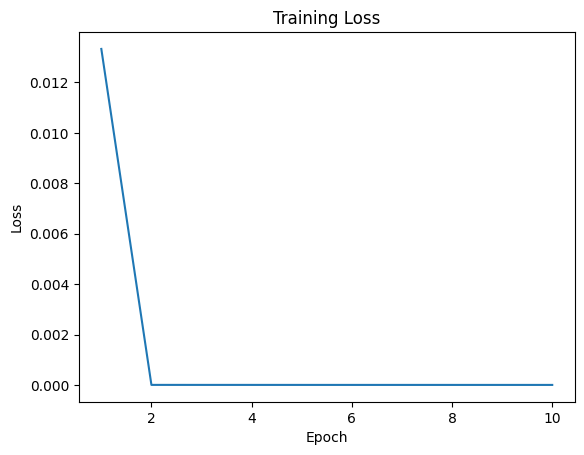

In [18]:
import numpy as np
import torch
import sentencepiece as spm
import tensorflow as tf
from keras import models, layers
from Juliet2_Schema import VLW, engine
from sqlalchemy.orm import sessionmaker
from tqdm import tqdm
import matplotlib.pyplot as plt

session = sessionmaker(bind=engine)
session = session()

# Load the trained SentencePiece model
sp = spm.SentencePieceProcessor()
sp.Load("m.model")

# Define the vocabulary size and embedding dimension
vocab_size = len(sp)
embedding_dim = 100  # Adjust this dimension based on your requirements

# Define the LSTM model
Juliet = models.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),  # Input layer for token embeddings
    layers.Bidirectional(layers.LSTM(units=128, return_sequences=True)),  # Bidirectional LSTM layer
    layers.TimeDistributed(layers.Dense(units=1, activation='sigmoid'))  # Time-distributed Dense layer for token classification
])

# Compile the model
Juliet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Generate training data (example, replace with your data)

num_train=5000
num_test=1000
index = 21
token = 'VULNERABILITY'


training_records = session.query(VLW.vlw_content, VLW.cwe_int).filter(VLW.model_id == 0).limit(num_train).all()
testing_records = session.query(VLW.vlw_content, VLW.cwe_int).filter(VLW.model_id == 1).limit(num_test).all()

train_texts = []
test_texts = []

print(len(training_records))
print(len(testing_records))

# Get Training Data
for record in training_records:
    vlw_content, cwe_int = record
    if cwe_int == 1:
        vlw_content_list = vlw_content.split('\n')    
        if len(vlw_content_list) > 21:  # Ensure there are at least 20 lines
            vlw_content_list.insert(21, token)
        # Join the list back into a string with newlines between elements
        vlw_content_str = '\n'.join(vlw_content_list)
        # Append the string to train_texts
        train_texts.append(vlw_content_str)

# Get Testing Data
for record in testing_records:
    vlw_content, cwe_int = record
    if cwe_int == 1:
        vlw_content_list = vlw_content.split('\n')    
        test_texts.append(vlw_content_list)
        
torch.manual_seed(620)
# Tokenize training texts and pad sequences
train_sequences = [sp.EncodeAsIds(text) for text in train_texts]
train_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, padding='post')
train_labels = [[1 if token == "VULNERABILITY" else 0 for token in sp.EncodeAsPieces(text)] for text in train_texts]  # Example: Label 1 for occurrence of "TOKEN"
train_labels_padded = tf.keras.preprocessing.sequence.pad_sequences(train_labels, padding='post')
# Train the model
epochs = 10
batch_size = 32
# Lists to store training loss and epoch number for plotting
losses = []
epochs_list = []

# Iterate over the epochs and wrap the loop with tqdm for progress visualization
for epoch in tqdm(range(epochs), desc="Training Epochs"):
    # Inside the loop, call model.fit() for each epoch
    history = Juliet.fit(train_sequences_padded, np.array(train_labels_padded), epochs=1, batch_size=batch_size, verbose=0)
    # Check if history.history['loss'] is not empty before appending
    if history.history['loss']:
        losses.append(history.history['loss'][0])
        epochs_list.append(epoch + 1)
    
    # Print the current loss
        print(f"Epoch {epoch+1}/{epochs}, Loss: {history.history['loss'][0]}")
    else:
        print(f"Epoch {epoch+1}/{epochs}, No loss recorded.")
    
    # Append the training loss and epoch number to lists
    losses.append(history.history['loss'][0])
    epochs_list.append(epoch + 1)

    # Print the current loss
    print(f"Epoch {epoch+1}/{epochs}, Loss: {history.history['loss'][0]}")

# Plot the loss graph over epochs
plt.plot(epochs_list, losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

First Trial Training Loss Depicted Above, Run 0


Average sequence length: 41.0


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (41,) + inhomogeneous part.

In [37]:
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm

maxlen = 41

# Tokenize validation texts and pad sequences
val_sequences = [sp.EncodeAsIds(text) for text in test_texts]



# Convert validation labels to binary
val_labels = [[1 if token == "VULNERABILITY" else 0 for token in sp.EncodeAsPieces(text)] for text in test_texts]

# Predict labels for validation data
val_predictions = []
for sequence in val_sequences:
    try:
        # Ensure the sequence is a 2D array
        sequence = np.array(sequence, dtype='int32')
        sequence = np.expand_dims(sequence, axis=0)
        prediction = Juliet.predict(sequence)
        val_predictions.append(prediction)
    except ValueError as e:
        print(f"Error: {e}")
        print(f"Problematic sequence: {sequence}")
val_predictions = np.array(val_predictions).ravel()
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(val_predictions, val_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
Error: Exception encountered when calling TimeDistributed.call().

Invalid dtype: NoneType

Arguments received by TimeDistributed.call():
  • inputs=tf.Tensor(shape=(1, None, 256), dtype=float32)
  • training=False
  • mask=None
Problematic sequence: [[8], [669, 1048], [40, 23, 713, 147, 416, 13929, 335, 13926], [7], [598, 13929, 335, 13925, 713, 6], [8], [21, 285, 348, 389, 244], [40, 23, 1117, 13926], [7], [1118, 63], [8], [21, 94], [8], [77, 948, 13956, 12, 15, 13928], [8], [7], [99, 15, 12, 77, 948, 933], [7], [], [15, 2841], [99, 351, 12, 15, 13928], [588, 13925, 481, 6], [8], [8], [8], [], [21, 94], [], [21, 136, 307], [], [], [149, 78, 126, 13958, 13953, 33], [7], [99, 15, 13928], [99, 77, 948, 13956, 12, 386, 10, 13928], [99, 77, 948, 13958, 12, 386, 10, 13928], [], [15, 12, 183], [7], [99, 15, 12, 77, 948, 1622], []]
Error: Exception encountered when calling TimeDistributed.call().

Invalid dtype: NoneType

Arguments received by TimeDistr

KeyboardInterrupt: 